### 1. ASCII output from CliDB

In [1]:
ascii_text_file = '/Users/nicolasf/Desktop/tmp/rain_decile_1month.txt'

In [2]:
file_format = pd.read_csv(ascii_text_file, names=['Data'])
file_format.head(10)

,Data
0,NCOLS 2274
1,NROWS 3232
2,XLLCORNER 1980000.0000000
3,YLLCORNER 5292000.0000000
4,CELLSIZE 500.00000000000
5,NODATA_VALUE -9999.000
6,-9999.0 -9999.0 -9999.0 -9999.0 -99...
7,-9999.0 -9999.0 -9999.0 -9999.0 -99...
8,-9999.0 -9999.0 -9999.0 -9999.0 -99...
9,-9999.0 -9999.0 -9999.0 -9999.0 -99...


### 2. Script to read in above file and write out to NETCDF format.

In [3]:
%matplotlib inline

In [4]:
import pyproj
import pandas as pd
import osr
from gdalconst import *
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, cm

In [5]:
gdal.UseExceptions()

In [6]:
def get_img(filename): 
    dataset = gdal.Open(filename, gdal.GA_ReadOnly)
    inSRS = 'PROJCS["New Zealand Map Grid",GEOGCS["International 1909 (Hayford)",DATUM["unknown",\
    SPHEROID["intl",6378388,297]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],\
    PROJECTION["New_Zealand_Map_Grid"],PARAMETER["latitude_of_origin",-41],PARAMETER["central_meridian",173],\
    PARAMETER["false_easting",2510000],PARAMETER["false_northing",6023150],UNIT["Meter",1],\
    EXTENSION["PROJ4","+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +ellps=intl\
    +units=m +nadgrids=nzgd2kgrid0005.gsb +wktext"]]'
    inSRS_converter = osr.SpatialReference()# makes an empty spatial ref object
    inSRS_converter.ImportFromWkt(inSRS)# populates the spatial ref object with our WKT SRS
    inSRS_forPyProj = inSRS_converter.ExportToProj4()

    arr = dataset.ReadAsArray()
    gt = dataset.GetGeoTransform()
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    min_lon = gt[0] 
    min_lat = gt[3] + rows*gt[5]  
    max_lon = gt[0] + cols*gt[1]
    max_lat = gt[3] 
    return arr, (min_lon, max_lon, min_lat, max_lat), inSRS_forPyProj,inSRS 

In [7]:
def get_extent(georef, extent): 
    inproj = pyproj.Proj(georef)
    georef_out = '+proj=longlat +datum=WGS84 +no_defs '
    outproj = pyproj.Proj(georef_out)
    lonmin, latmin = pyproj.transform(inproj, outproj, extent[0], extent[2])
    lonmax, latmax = pyproj.transform(inproj, outproj, extent[1], extent[3])
    extent_conv = (lonmin, lonmax, latmin, latmax)
    return latmin, latmax, lonmin, lonmax, extent_conv

In [8]:
arr, extent, georef,inSRS = get_img(ascii_text_file)

In [9]:
arr # This is going to be the variable of netcdf output. 

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ..., 
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]], dtype=float32)

In [10]:
latmin2, latmax2, lonmin2, lonmax2, extent_conv2 = get_extent(georef, extent)

In [11]:
extent_conv2  #current nzmg

(165.9811695299988, 179.45472496347858, -47.37619698004963, -32.84291783512453)

#### Convert -9999 (NoData value) to 0 for size reduction of output

In [12]:
reduc_arr = arr.copy()
np.place(reduc_arr, arr == -9999. , [0])
#test file size here;
#np.savetxt('/home/paul/Downloads/Data_test/arr.csv',dupl_arr,delimiter=',',fmt='%d')

#### Plot above array (reduc_arr) on a map

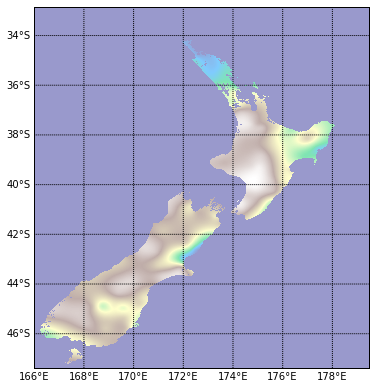

In [13]:
fig,ax = plt.subplots(figsize=(6,8))
map1 = Basemap(llcrnrlon=lonmin2,llcrnrlat=latmin2,urcrnrlon=lonmax2,urcrnrlat=latmax2, resolution = 'h', epsg=4326,ax=ax)
plt.imshow(reduc_arr ,interpolation='nearest', extent=extent_conv2 ,vmin=0,cmap = plt.get_cmap('terrain'), alpha = 0.5)
# draw parallels
map1.drawparallels(np.arange(-90,90,2),labels=[1,0,0,1])
# draw meridians
map1.drawmeridians(np.arange(-180,180,2),labels=[1,0,0,1])
plt.show()

In [15]:
reduc_arr.shape

(3232, 2274)

### 3. Create NETCDF

In [61]:
from netCDF4 import Dataset
# Create HDF5 *format*, classic *model*
dataset = Dataset('/Users/nicolasf/Desktop/tmp/rain_1month_decile1.nc', 'w', format='NETCDF4_CLASSIC')
print dataset.file_format

NETCDF4_CLASSIC


In [62]:
lat   = dataset.createDimension('lat',  reduc_arr.shape[0])
lon   = dataset.createDimension('lon', reduc_arr.shape[1])

In [63]:
latitudes  = dataset.createVariable('latitude',np.float32, ('lat',))
longitudes = dataset.createVariable('longitude',np.float32, ('lon',))

In [64]:
rain = dataset.createVariable('rain',np.float32,('lat','lon',))

In [65]:
lats = np.linspace(165.9811695299988,179.45472496347858, reduc_arr.shape[0], endpoint=True)
lons = np.linspace(-47.37619698004963,-32.84291783512453, reduc_arr.shape[1], endpoint=True)

In [66]:
latitudes[:] = lats
longitudes[:] = lons

In [67]:
rain[:,:] = reduc_arr

In [68]:
dataset.close()

### reads the created netcdf using XRAY

In [69]:
import xray

In [70]:
dset = xray.open_dataset('/Users/nicolasf/Desktop/tmp/rain_1month_decile1.nc')

In [71]:
dset

<xray.Dataset>
Dimensions:    (lat: 3232, lon: 2274)
Coordinates:
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 ...
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 ...
Data variables:
    latitude   (lat) float32 165.981 165.985 165.99 165.994 165.998 166.002 166.006 166.01 ...
    longitude  (lon) float32 -47.3762 -47.3698 -47.3634 -47.357 -47.3506 -47.3442 -47.3378 ...
    rain       (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [72]:
dec = dset['rain']

In [73]:
dec.shape

(3232, 2274)

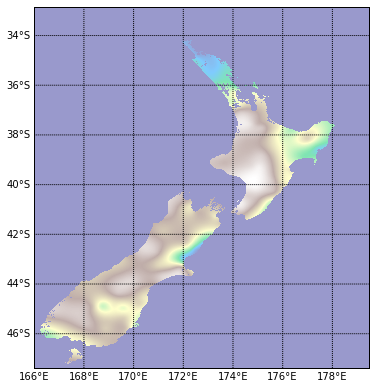

In [76]:
fig,ax = plt.subplots(figsize=(6,8))
map1 = Basemap(llcrnrlon=lonmin2,llcrnrlat=latmin2,urcrnrlon=lonmax2,urcrnrlat=latmax2, resolution = 'h', epsg=4326,ax=ax)
plt.imshow(dec ,interpolation='nearest', extent=extent_conv2 ,vmin=0,cmap = plt.get_cmap('terrain'), alpha = 0.5)
# draw parallels
map1.drawparallels(np.arange(-90,90,2),labels=[1,0,0,1])
# draw meridians
map1.drawmeridians(np.arange(-180,180,2),labels=[1,0,0,1])
plt.show()